# Unveiling DBSCAN: A Powerful Density-Based Clustering Technique

This notebook has two parts:
- **Part 1:** Intuition with a synthetic `make_circles` dataset.
- **Part 2:** Practical customer segmentation with the Mall Customers dataset (https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python).


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)


## Part 1: Intuition with `make_circles`

We start with a 2D synthetic dataset of concentric circles. This is a classic example where density-based clustering like DBSCAN outperforms algorithms assuming spherical clusters.


**Generate make_circles**

In [ ]:
X_circles, y_circles = make_circles(
    n_samples=500,
    noise=0.05,
    factor=0.5,
    random_state=42
)

print("X_circles shape:", X_circles.shape)
print("y_circles shape:", y_circles.shape)


X_circles shape: (500, 2)
y_circles shape: (500,)


**Plot raw make_circles data**

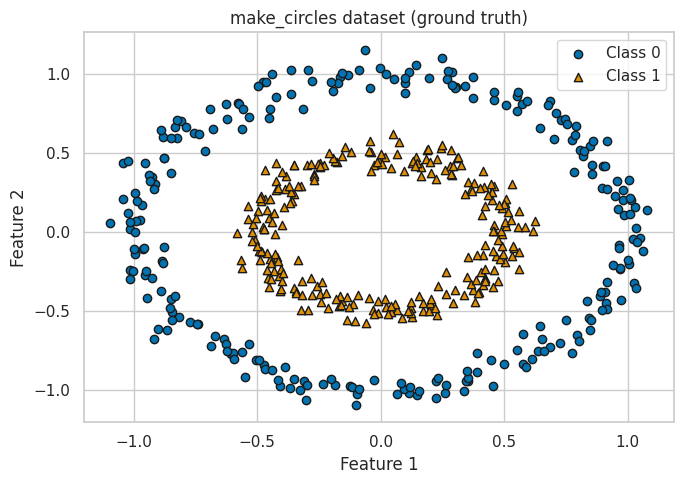

In [ ]:
def plot_circles_raw(X, y):
    palette = sns.color_palette("colorblind", 2)
    plt.figure()
    plt.scatter(
        X[y == 0, 0], X[y == 0, 1],
        c=[palette[0]], marker="o", edgecolor="k", label="Class 0"
    )
    plt.scatter(
        X[y == 1, 0], X[y == 1, 1],
        c=[palette[1]], marker="^", edgecolor="k", label="Class 1"
    )
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("make_circles dataset (ground truth)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_circles_raw(X_circles, y_circles)


**Scale the features**

In [ ]:
scaler_circles = StandardScaler()
X_circles_scaled = scaler_circles.fit_transform(X_circles)

print("First 5 rows before scaling:\n", X_circles[:5])
print("\nFirst 5 rows after scaling:\n", X_circles_scaled[:5])


First 5 rows before scaling:
 [[-0.46927625  0.21011823]
 [-0.16416437  0.98607538]
 [-0.47145368  0.01997413]
 [-0.67034684 -0.65797711]
 [-0.82646813  0.59407104]]

First 5 rows after scaling:
 [[-0.84430554  0.37432909]
 [-0.30061444  1.76559307]
 [-0.84818559  0.0334074 ]
 [-1.20260131 -1.18213541]
 [-1.48080011  1.06274303]]


**Helper to plot DBSCAN clusters**

In [ ]:
def plot_dbscan_clusters(X, labels, title, xlabel="Feature 1", ylabel="Feature 2"):
    plt.figure()
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    base_colors = sns.color_palette("colorblind", max(n_clusters, 1))
    noise_color = (0.6, 0.6, 0.6)

    for lab in unique_labels:
        if lab == -1:
            color = [noise_color]
            lab_name = "Noise"
            marker = "x"
            # no edgecolor for 'x' marker
            plt.scatter(
                X[labels == lab, 0],
                X[labels == lab, 1],
                c=color,
                marker=marker,
                label=lab_name,
                alpha=0.8
            )
        else:
            color = [base_colors[lab % len(base_colors)]]
            lab_name = f"Cluster {lab}"
            marker = "o"
            plt.scatter(
                X[labels == lab, 0],
                X[labels == lab, 1],
                c=color,
                marker=marker,
                edgecolor="k",
                label=lab_name,
                alpha=0.8
            )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.
    )
    plt.tight_layout()
    plt.show()


**Run DBSCAN on make_circles**

Unique labels: [-1  0  1  2  3  4]


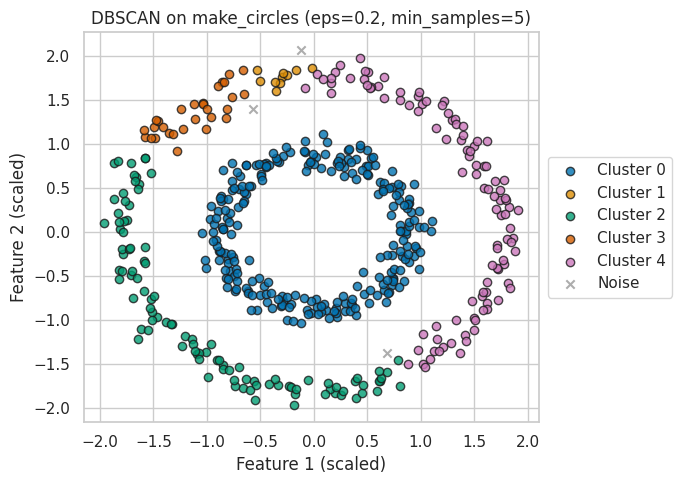

In [ ]:
dbscan_circles = DBSCAN(eps=0.2, min_samples=5)
labels_circles = dbscan_circles.fit_predict(X_circles_scaled)

print("Unique labels:", np.unique(labels_circles))

plot_dbscan_clusters(
    X_circles_scaled,
    labels_circles,
    "DBSCAN on make_circles (eps=0.2, min_samples=5)",
    xlabel="Feature 1 (scaled)",
    ylabel="Feature 2 (scaled)"
)


**Silhouette helper**

In [ ]:
def silhouette_if_possible(X, labels):
    unique = set(labels)
    if -1 in unique:
        unique.remove(-1)
    if len(unique) < 2:
        return None
    mask = labels != -1
    return silhouette_score(X[mask], labels[mask])


**Vary eps and plot**

eps=0.1: clusters=24, noise=247, silhouette=0.48937476720732237


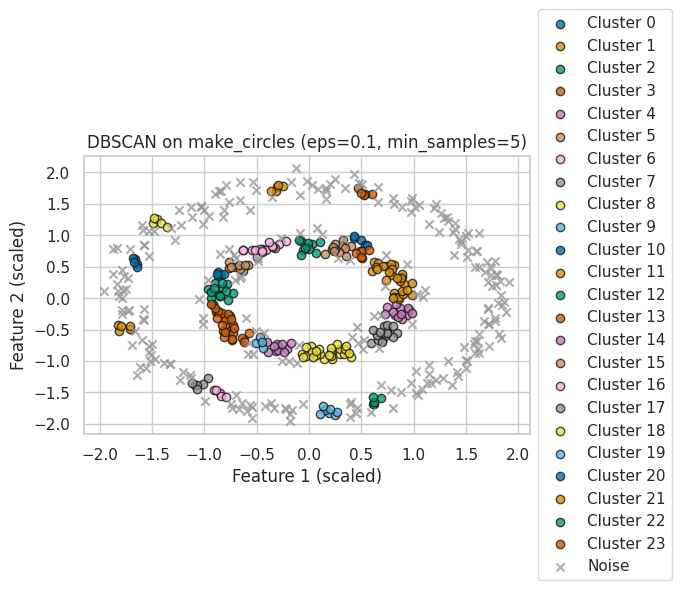

eps=0.15: clusters=19, noise=41, silhouette=0.10690595272310681


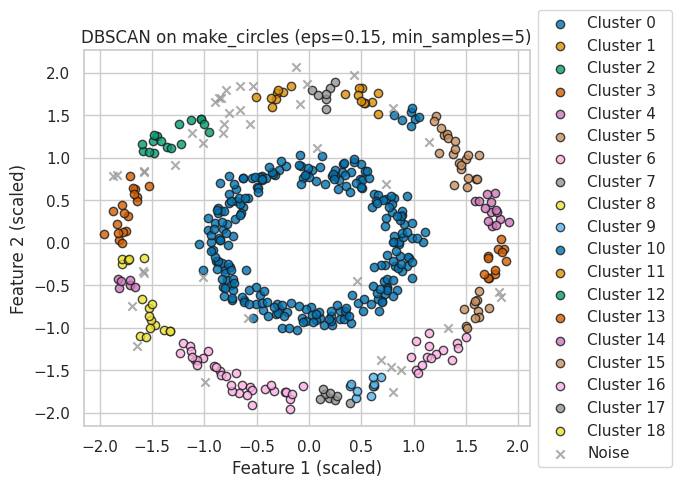

eps=0.2: clusters=5, noise=3, silhouette=0.12309959855402573


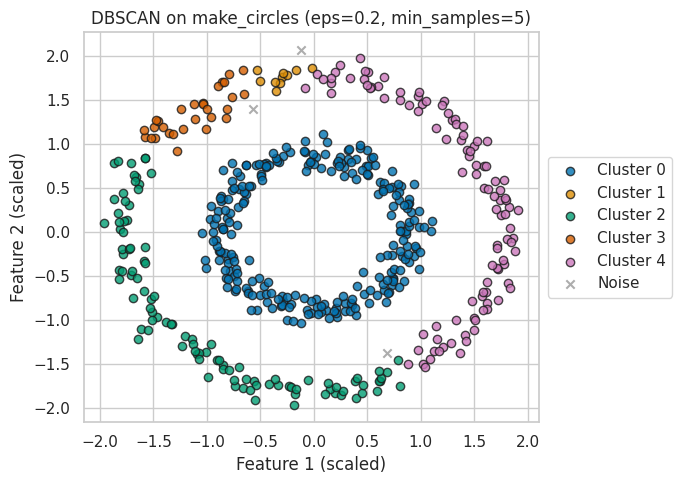

eps=0.25: clusters=2, noise=0, silhouette=0.11260238626705125


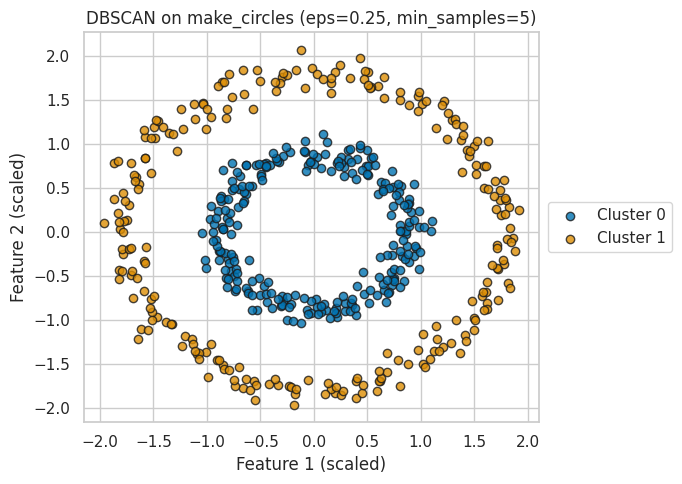

eps=0.3: clusters=2, noise=0, silhouette=0.11260238626705125


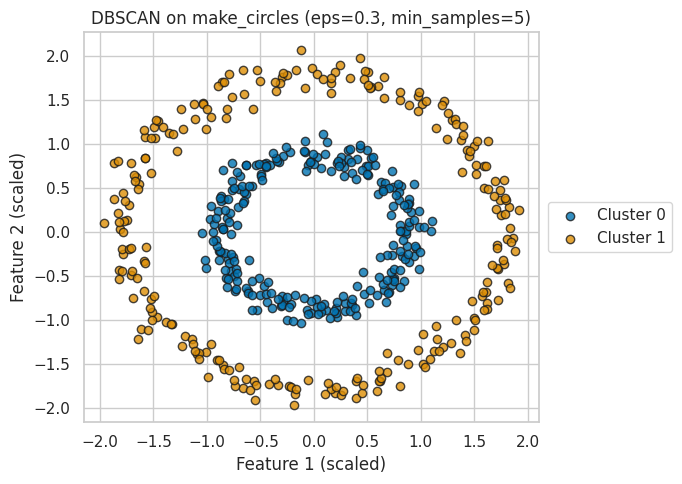

,eps,n_clusters,n_noise,silhouette
0,0.10,24,247,0.489375
1,0.15,19,41,0.106906
2,0.20,5,3,0.123100
3,0.25,2,0,0.112602
4,0.30,2,0,0.112602


In [ ]:
eps_values = [0.1, 0.15, 0.2, 0.25, 0.3]
circles_results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_circles_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in set(labels) else 0)
    n_noise = np.sum(labels == -1)
    sil = silhouette_if_possible(X_circles_scaled, labels)
    circles_results.append((eps, n_clusters, n_noise, sil))

    print(f"eps={eps}: clusters={n_clusters}, noise={n_noise}, silhouette={sil}")
    plot_dbscan_clusters(
        X_circles_scaled,
        labels,
        f"DBSCAN on make_circles (eps={eps}, min_samples=5)",
        xlabel="Feature 1 (scaled)",
        ylabel="Feature 2 (scaled)"
    )

circles_results_df = pd.DataFrame(
    circles_results,
    columns=["eps", "n_clusters", "n_noise", "silhouette"]
)
circles_results_df


### Effect of `eps` on circles: number of clusters, noise, and quality

The table above summarizes how different values of `eps` affect DBSCAN on the `make_circles` dataset.  
Very small `eps` values (for example 0.10) create many tiny clusters and a large number of noise points, while larger values (around 0.25–0.30) merge the points into two meaningful clusters that match the inner and outer rings. The silhouette score helps quantify how well separated and compact the clusters are for each setting.


**The “best” circles plot**

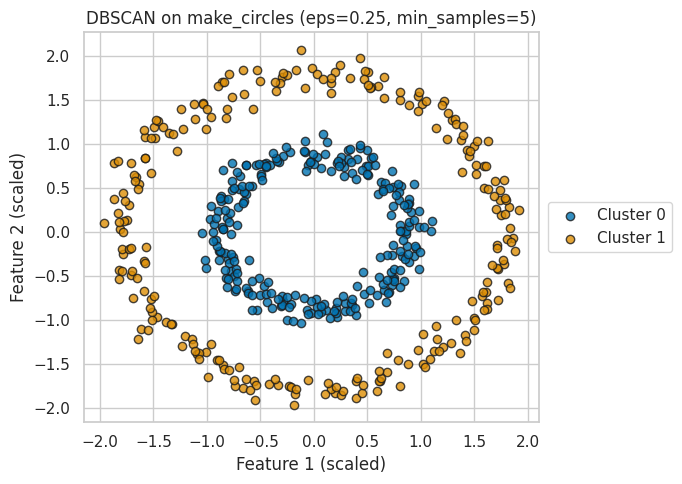

In [ ]:
# Final DBSCAN model for make_circles with a good eps
dbscan_circles_good = DBSCAN(eps=0.25, min_samples=5)
labels_circles_good = dbscan_circles_good.fit_predict(X_circles_scaled)

plot_dbscan_clusters(
    X_circles_scaled,
    labels_circles_good,
    "DBSCAN on make_circles (eps=0.25, min_samples=5)",
    xlabel="Feature 1 (scaled)",
    ylabel="Feature 2 (scaled)"
)


### DBSCAN on `make_circles`: discovering non‑convex clusters

Here DBSCAN is applied to the scaled `make_circles` dataset with `eps = 0.25` and `min_samples = 5`.  
These parameters allow the algorithm to correctly recover the two circular clusters that are not linearly separable, while treating no points as noise. This illustrates how density‑based clustering can follow the true geometric shape of the data, unlike algorithms that assume spherical clusters such as k‑means.


## Part 2: DBSCAN for Mall Customer Segmentation

We now apply DBSCAN to the Mall Customers dataset from Kaggle, using annual income and spending score to discover dense customer segments and possible outliers.


In [ ]:
import pandas as pd

In [ ]:
file_path = "Mall_Customers.csv"  # change if your filename/path is different
mall = pd.read_csv(file_path)
mall.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Basic info and missing values**


In [ ]:
mall.info()
print("\nMissing values per column:")
print(mall.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Missing values per column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


**Select numeric features for clustering**

In [ ]:
features = ["Annual Income (k$)", "Spending Score (1-100)"]
X_mall = mall[features].copy()

print(X_mall.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


**Raw scatterplot of customers**

In [ ]:
import seaborn as sns

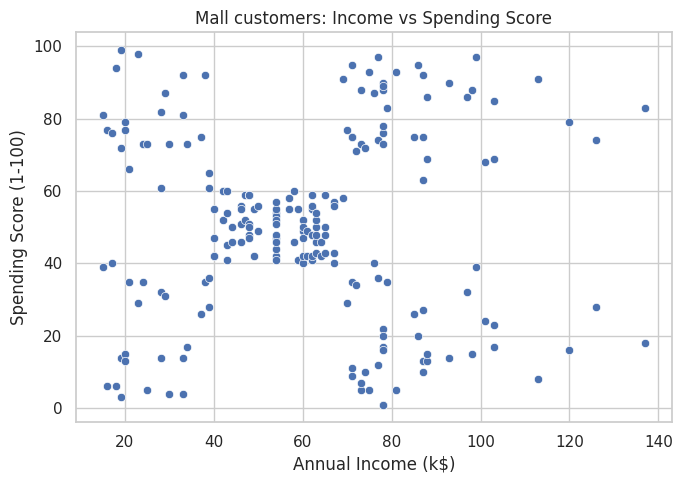

In [ ]:
sns.scatterplot(
    data=X_mall,
    x="Annual Income (k$)",
    y="Spending Score (1-100)"
)
plt.title("Mall customers: Income vs Spending Score")
plt.tight_layout()
plt.show()

### Visualising mall customers in income–spending space

This scatterplot shows each customer’s annual income and spending score.  
The dense bands around the middle of the plot suggest groups of customers with similar spending behaviour, while isolated points at the extremes hint at potential outliers. This 2D view will be used as the basis for DBSCAN clustering.


**Scale features**

In [ ]:
scaler_mall = StandardScaler()
X_mall_scaled = scaler_mall.fit_transform(X_mall)

print("Scaled mall shape:", X_mall_scaled.shape)
print("First 5 rows (scaled):\n", X_mall_scaled[:5])

Scaled mall shape: (200, 2)
First 5 rows (scaled):
 [[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]


**Initial DBSCAN on Mall Customers**


In [ ]:
dbscan_mall = DBSCAN(eps=0.5, min_samples=5)
labels_mall = dbscan_mall.fit_predict(X_mall_scaled)

unique_labels, counts = np.unique(labels_mall, return_counts=True)
print("Unique labels:", unique_labels)
print("Counts:", counts)


Unique labels: [-1  0  1]
Counts: [  8 157  35]


**Plot Mall DBSCAN clusters**

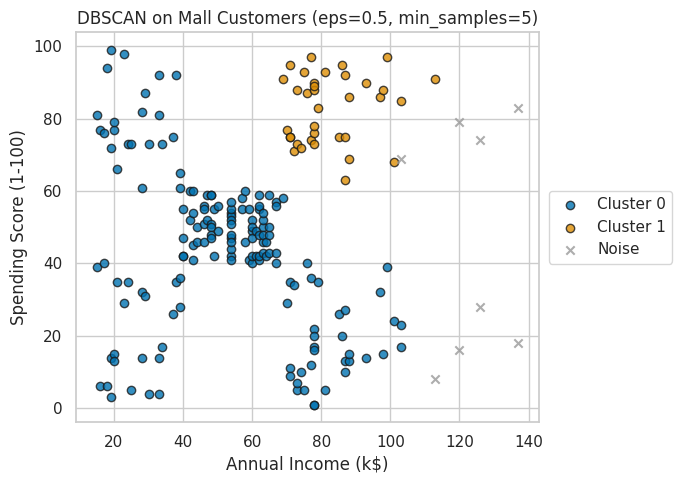

In [ ]:
def plot_mall_clusters(X_original, labels, title):
    plt.figure()
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    base_colors = sns.color_palette("colorblind", max(n_clusters, 1))
    noise_color = (0.6, 0.6, 0.6)

    for lab in unique_labels:
        if lab == -1:
            color = [noise_color]
            lab_name = "Noise"
            marker = "x"
            plt.scatter(
                X_original[labels == lab, 0],
                X_original[labels == lab, 1],
                c=color,
                marker=marker,
                label=lab_name,
                alpha=0.8
            )
        else:
            color = [base_colors[lab % len(base_colors)]]
            lab_name = f"Cluster {lab}"
            marker = "o"
            plt.scatter(
                X_original[labels == lab, 0],
                X_original[labels == lab, 1],
                c=color,
                marker=marker,
                edgecolor="k",
                label=lab_name,
                alpha=0.8
            )

    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1-100)")
    plt.title(title)
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.
    )
    plt.tight_layout()
    plt.show()

plot_mall_clusters(
    X_mall.values,
    labels_mall,
    "DBSCAN on Mall Customers (eps=0.5, min_samples=5)"
)


### First DBSCAN result on Mall Customers (eps = 0.5)

With `eps = 0.5` and `min_samples = 5`, DBSCAN finds two customer clusters and a small set of noise points.  
This already shows DBSCAN’s ability to leave some customers unassigned when they are too isolated, but the choice of `eps` is still arbitrary. In the next step, a more principled approach is used to tune this parameter.

**k‑distance plot (for choosing eps)**

In [ ]:
from sklearn.neighbors import NearestNeighbors


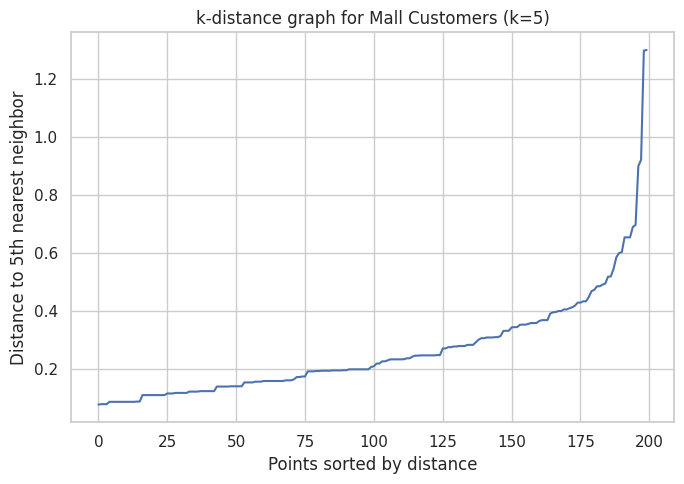

In [ ]:
k = 5  # same as min_samples
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(X_mall_scaled)
distances, indices = nbrs.kneighbors(X_mall_scaled)

k_distances = np.sort(distances[:, -1])

plt.figure()
plt.plot(k_distances)
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.title("k-distance graph for Mall Customers (k=5)")
plt.tight_layout()
plt.show()


### Choosing `eps` with a k‑distance plot

The k‑distance graph plots the distance from each point to its 5th nearest neighbour, sorted in ascending order.  
The curve stays relatively flat for small distances, then bends upward roughly between 0.25 and 0.40, suggesting that this is a sensible range for `eps`: smaller values risk labelling many customers as noise, while much larger values may merge distinct segments together.


**Grid over eps**

In [ ]:
eps_candidates = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
mall_results = []

for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_mall_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in set(labels) else 0)
    n_noise = np.sum(labels == -1)
    sil = silhouette_if_possible(X_mall_scaled, labels)
    mall_results.append((eps, n_clusters, n_noise, sil))
    print(f"eps={eps}: clusters={n_clusters}, noise={n_noise}, silhouette={sil}")

mall_results_df = pd.DataFrame(
    mall_results,
    columns=["eps", "n_clusters", "n_noise", "silhouette"]
)
mall_results_df


eps=0.2: clusters=7, noise=77, silhouette=0.5856126991466907
eps=0.25: clusters=6, noise=50, silhouette=0.531656604742725
eps=0.3: clusters=7, noise=35, silhouette=0.5243276105881419
eps=0.35: clusters=6, noise=23, silhouette=0.5577457478878458
eps=0.4: clusters=4, noise=15, silhouette=0.4780592455223124
eps=0.5: clusters=2, noise=8, silhouette=0.3875583892728279


,eps,n_clusters,n_noise,silhouette
0,0.20,7,77,0.585613
1,0.25,6,50,0.531657
2,0.30,7,35,0.524328
3,0.35,6,23,0.557746
4,0.40,4,15,0.478059
5,0.50,2,8,0.387558


### Tuning `eps` on Mall Customers

This table shows how DBSCAN behaves on the mall data for different values of `eps`.  
Values between 0.20 and 0.35 yield several distinct customer clusters with relatively high silhouette scores and a moderate number of noise points, while larger `eps` values reduce the number of clusters but also mix together groups that look separable in the income–spending space. Based on this trade‑off, `eps = 0.35` is selected for the final model.


**Final DBSCAN on Mall Customers**

Unique labels: [-1  0  1  2  3  4  5]
Silhouette (excluding noise): 0.5577457478878458


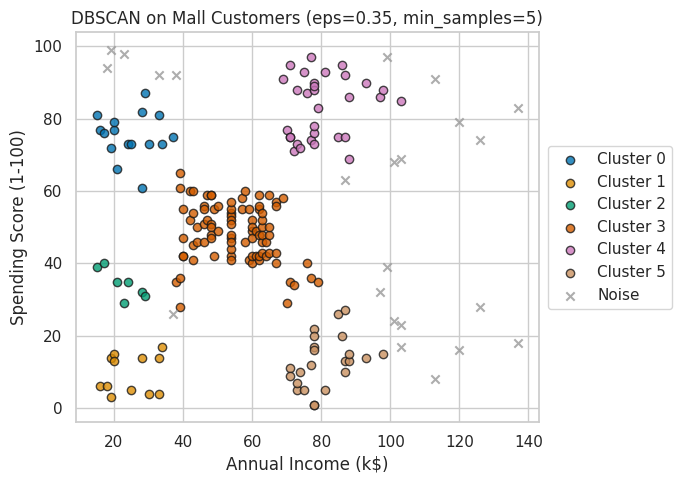

In [ ]:
best_eps = 0.35  # you can change to another value from the table if you prefer

dbscan_mall_best = DBSCAN(eps=best_eps, min_samples=5)
labels_mall_best = dbscan_mall_best.fit_predict(X_mall_scaled)

print("Unique labels:", np.unique(labels_mall_best))
print("Silhouette (excluding noise):", silhouette_if_possible(X_mall_scaled, labels_mall_best))

plot_mall_clusters(
    X_mall.values,
    labels_mall_best,
    f"DBSCAN on Mall Customers (eps={best_eps}, min_samples=5)"
)


### Final DBSCAN segmentation of mall customers

Using `eps = 0.35` and `min_samples = 5`, DBSCAN identifies six dense customer segments and a set of outlier customers marked as noise.  
Segments correspond to intuitive business groups such as high‑income high‑spending customers, low‑income low‑spending customers, and mid‑income customers with average spending, while noise points represent unusual income–spending profiles. The silhouette score around 0.56 indicates reasonably compact and well‑separated segments.

**KMeans comparison**

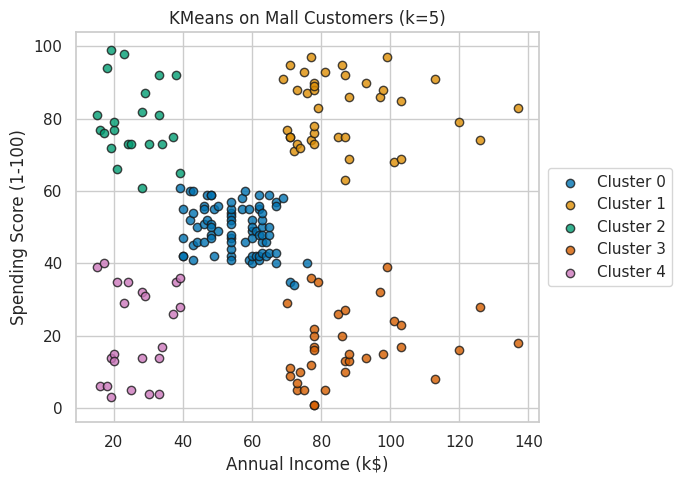

KMeans silhouette: 0.5546571631111091


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(X_mall_scaled)

plot_mall_clusters(
    X_mall.values,
    kmeans_labels,
    "KMeans on Mall Customers (k=5)"
)

kmeans_sil = silhouette_score(X_mall_scaled, kmeans_labels)
print("KMeans silhouette:", kmeans_sil)


### Comparing DBSCAN with k‑means on Mall Customers

For comparison, k‑means with \(k = 5\) is applied to the same scaled mall data.  
K‑means achieves a silhouette score similar to DBSCAN, but forces every customer into one of five roughly spherical clusters and cannot label outliers, whereas DBSCAN can capture irregularly shaped dense regions and explicitly identify isolated customers as noise. This highlights when density‑based clustering can provide more nuanced insight for customer segmentation.

## Conclusion

This tutorial demonstrated how DBSCAN, a density-based clustering algorithm, can successfully discover clusters of arbitrary shape and identify noise without requiring the number of clusters in advance. On the synthetic `make_circles` dataset, DBSCAN recovered the inner and outer rings as two coherent clusters once `eps` was chosen appropriately, while very small `eps` values fragmented the data into many tiny groups with high noise.

Applied to the Mall Customers dataset, DBSCAN produced several meaningful customer segments in the income–spending space and explicitly marked isolated customers as noise, with a silhouette score comparable to that of k‑means clustering. This highlights DBSCAN’s usefulness for exploratory data analysis and segmentation when cluster shapes are irregular and outliers are important to detect.


## References

- Scikit-learn developers. “DBSCAN — Density-Based Spatial Clustering of Applications with Noise”, scikit-learn documentation (version 1.7.2).
- Scikit-learn developers. “make_circles — Generated datasets”, scikit-learn documentation (version 1.7.2).
- Kaggle. “Mall Customer Segmentation Data”, dataset by vjchoudhary7.
- Sefidian, A. “How to determine epsilon and MinPts parameters of DBSCAN clustering?”, technical blog.  
- GeeksforGeeks / tutorial sources explaining DBSCAN implementation and concepts in Python.
- Articles and tutorials on k-means and customer segmentation using the Mall Customers dataset.


**Save main figures and CSVs**


<Figure size 700x500 with 0 Axes>

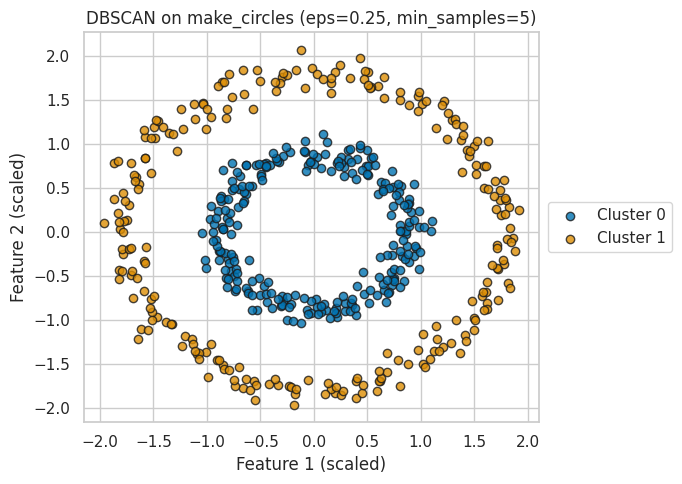

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

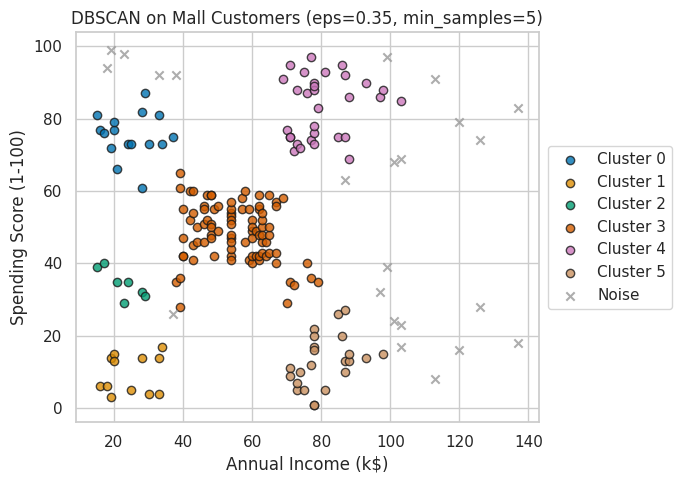

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

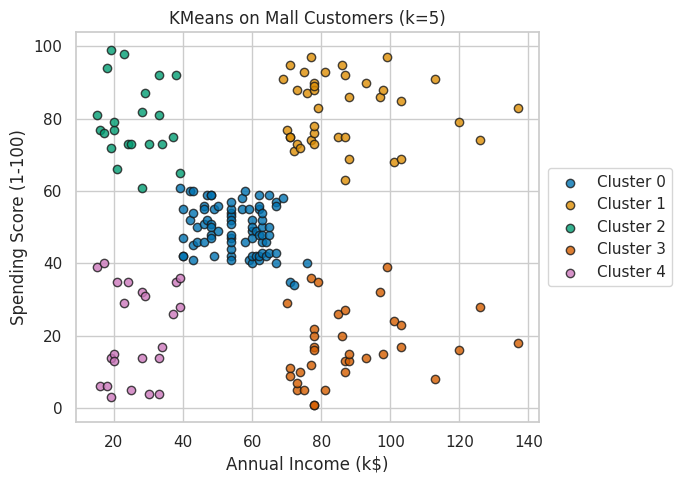

<Figure size 700x500 with 0 Axes>

In [ ]:
# 1) DBSCAN on make_circles for a good eps (e.g., 0.25)
dbscan_circles_good = DBSCAN(eps=0.25, min_samples=5)
labels_circles_good = dbscan_circles_good.fit_predict(X_circles_scaled)

plt.figure()
plot_dbscan_clusters(
    X_circles_scaled,
    labels_circles_good,
    "DBSCAN on make_circles (eps=0.25, min_samples=5)",
    xlabel="Feature 1 (scaled)",
    ylabel="Feature 2 (scaled)"
)
plt.savefig("fig_dbscan_circles_eps0_25.png", dpi=300, bbox_inches="tight")

# 2) Best DBSCAN on Mall Customers
plt.figure()
plot_mall_clusters(
    X_mall.values,
    labels_mall_best,
    f"DBSCAN on Mall Customers (eps={best_eps}, min_samples=5)"
)
plt.savefig("fig_dbscan_mall_best.png", dpi=300, bbox_inches="tight")

# 3) KMeans on Mall Customers
plt.figure()
plot_mall_clusters(
    X_mall.values,
    kmeans_labels,
    "KMeans on Mall Customers (k=5)"
)
plt.savefig("fig_kmeans_mall_k5.png", dpi=300, bbox_inches="tight")

# 4) Save parameter-sweep tables
circles_results_df.to_csv("circles_dbscan_results.csv", index=False)
mall_results_df.to_csv("mall_dbscan_results.csv", index=False)
